In [101]:
print("Hello world!")

Hello world!


In [26]:
#import necessary packages
import numpy as np
from tabulate import tabulate
from math import *
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat

In [27]:
def dividdif(x,y):
    n = len(x)
    m = len(y)
    if n!=m:
        raise Exception("Error, divided differences cannot be found if x and y are different lengths!")
    #initialize P
    DD = np.zeros((n, n))
    DD[:, 0]= np.squeeze(y) #first divided difference is f(xi)
    #calculate all the divided differences and store the needed ones on the top row (row 0)
    for j in range(1, n):
        for i in range(n - j):
            DD[i, j] = (DD[i + 1, j - 1] - DD[i, j - 1]) / (x[i + j] - x[i])
    P = DD[0,:]
    return P
        

In [28]:
def evalP(P, t_int, t_test):
    pt = np.zeros_like(t_test)
    n = len(P) #same num of divided diff as t_int
    m = len(t_test)
    for j in range(0,m):
        #Perform nested multiplication
        temp = P[n-1]#need to start with the nth divided difference
        for i in range((n-2), -1, -1):
            #recursively defines the value of the polynomial at t_test
            temp = temp*(t_test[j]-t_int[i])+P[i]
        pt[j] = temp
    return pt

In [29]:
#Test divided differences and evalP
x = [0,1,2,3]
y = [-4,2,6,8]
P = dividdif(x,y)
sizeP = P.size
print(sizeP)
t_test = [0.5,1.25,2.5]
pt = evalP(P, x, t_test)
print(pt)

4
[-0.75    3.1875  7.25  ]


In [30]:
#test spline3 natural with a known example from class
t = [-1,0,1]
ft = [1,2,-1]
S = spline3(t,ft)
print(S)

[[ 1.  2.  0. -1.]
 [ 2. -1. -3.  1.]]


In [31]:
#Now test the clamped condition with the known condition from class
t = [0, 1, 2]
ft = [1,1, 2]
S = spline3(t,ft, "clamped", 0, 11)
print(S)


[[ 1.  0.  2. -2.]
 [ 1. -2. -4.  7.]]


In [32]:
#function that evaluates the spline at points
def evalS(S, t_int, t_test):
    n = len(t_int) #the length of int points; there are n-1 polynomials
    m = len(t_test) #number of points needing tests
    st = np.zeros(m)
    for i in range(m): #create a loop to test each point i in t_test
        for j in range(n-1,-1,-1): #create a loop that checks which time interval i is in
            if t_test[i]-t_int[j] >= 0: 
                temp = t_test[i]-t_int[j]
                break
        if temp == t_test[i]-t_int[n-1]:
            st[i] = S[j-1, 0] + S[j-1, 1]*temp + S[j-1, 2]*(temp)**(2)+S[j-1, 3]*(temp)**(3)
        else: 
            st[i] = S[j, 0] + S[j, 1]*temp + S[j, 2]*(temp)**(2)+S[j, 3]*(temp)**(3)
    return st

In [33]:
#Now test evalS
t = [0, 1, 2]
ft = [1,1, 2]
t_test = [.5, 1.75]
S = spline3(t,ft, "clamped", 0, 11)
st = evalS(S, t, t_test)
print(st)
#This also works! Checked in Desmos

[1.25     0.203125]


In [34]:
#find path for parametric systems
def findpath(ip, tp, method, boundary = None, fxap = None, fxbp = None, fyap = None, fybp = None):
    #find the number of rows in ip, equivalent to the number of interpolation nodes t
    #create arrays from ip to run through functions
    t = ip[:,0]
    x = ip[:,1]
    y = ip[:,2]
    n = len(t)
    m = len(tp)
    coeff = np.zeros((n, 3)) 
    path = np.zeros((m, 3))
    if method == "lagrange":
        coeff = np.zeros((n, 3)) 
        #transpose the to row vectors just to be extra safe
        t = np.transpose(t)
        x = np.transpose(x)
        y = np.transpose(y)
        Px = dividdif(t, x) # find the x divided differences
        Py = dividdif(t, y) # find the y divided differences
        #transpose them back to column vectors
        t = np.transpose(t)
        Px = np.transpose(Px)
        Py = np.transpose(Py)
        #fill the coefficient matrix 
        coeff[:,0] = t 
        coeff[:,1] = Px
        coeff[:,2] = Py
        path[:, 0] = np.transpose(tp) #try this?
        #transpose one more time back to a row vector
        tp = np.transpose(tp)
        t = np.transpose(t)
        #eval returns a bunch of row vectors, will need to transpose to fill matrix
        col1 = evalP(Px, t, tp) 
        col2 = evalP(Py, t, tp)
        path[:,1] = col1
        path[:,2] = col2
        return path, coeff
    if method == "spline":
        coeff = np.zeros((n-1, 9)) #Splines have one less cubic than nodes
        #transpose the to row vectors just to be extra safe to run through functions
        t = np.transpose(t)
        x = np.transpose(x)
        y = np.transpose(y)
        if boundary == "clamped":
            if fxap == None or fyap == None or fxbp == None or fybp == None:
                raise Exception("Clamped boundary conditions needs f' inputs at t and tn for x(t) and y(t)")
            Sx = spline3(t,x,"clamped", fxap, fxbp) #find both of the matrices of the coefficients for x and #y 
            Sy = spline3(t, y, "clamped", fyap, fybp)
        else: #otherwise assume its natural
            Sx = spline3(t,x)
            Sy = spline3(t, y)
        #fill the coefficient matrix 
        coeff[:, [1,2,3,4]]=Sx
        coeff[:, [5,6,7,8]]=Sy
        for i in range(n-1): #instead of transposing and truncating an element of the vector
            coeff[i, 0]= t[i]
        #coefficients is done! Now find path!!
        #initializing path
        path[:, 0] = np.transpose(tp) #fill the first column of path
        
        col1 = evalS(Sx, t, tp)
        col2 = evalS(Sy, t, tp)
        path[:,1] = np.transpose(col1)
        path[:,2] = np.transpose(col2)
        return path, coeff
    

In [35]:
#create the cubic spline function
#boundary defaults to natural and fprimea and fprimeb default to empty without input
def spline3(t,ft, boundary = "natural", fprimea =None, fprimeb = None):
    n = len(t) #number of nodes, index on them runs from 0 to n-1
    h = np.zeros(n-1) #initalize empty array for time steps
    A = np.zeros((n-1, 1)) #constant
    B = np.zeros((n-1,1)) #linear coeff
    C = np.zeros((n-1,1)) #quad coeff
    D = np.zeros((n-1,1)) #cubic coeff
    S = np.zeros((n-1, 4))
    for i in range(n-1):
        h[i] = t[i+1]-t[i]
    # print(h)
    #Need to solve the tridiagonal system to find the m's
    #initalize matrix, lamda and mu vector
    R = np.zeros((n,n))
    #upper and lower diagonal have one less entry than the main diagonal
    lamda = np.zeros(n-1) 
    mu = np.zeros(n-1)
    r = np.zeros(n)
    for i in range(1,n-1):
        mu[i] = h[i]/(h[i-1]+h[i])
        lamda[i-1] = 1 - mu[i]
        r[i] = (6/(h[i]+h[i-1]))*((ft[i+1]-ft[i])/(h[i])-((ft[i])-ft[i-1])/h[0])
    for i in range(n): 
        R[i,i] = 2 #fill the main diagonal with 2's
    #apply boundary conditions
    if boundary == "natural":
        mu[0] = 0
        lamda[n-2] = 0
        r[0]=0
        r[n-1]=0
        #now finish filling R w/ respect to the boundary condition
        for i in range(1, n):
            R[i, i-1] = lamda[i-1] #lower diagonal
            R[i-1, i] = mu[i-1] #upper diagonal
        m = np.linalg.solve(R, r)
        #boundary condition for the m's 
        m[0]= 0 
        m[n-1] = 0
        for i in range(n-1): #check the indexing
            A[i] = ft[i]
            B[i] = ((ft[i+1] - ft[i])/h[i])- (h[i]*((m[i+1]+2*m[i])/6))
            C[i] = m[i]/2
            D[i] = (m[i+1]- m[i])/(6*h[i])
        A = np.transpose(A)
        B = np.transpose(B)
        C = np.transpose(C)
        D = np.transpose(D)
        S[:,0]=A
        S[:,1]=B
        S[:,2]=C
        S[:,3]=D
        #This condition works and has been checked by a an example
    if boundary == "clamped":
        #apply boundary conditions
        mu[0] = 1
        lamda[n-2] = 1
        r[0] = 6/((h[0])**(2))*(ft[1]-ft[0])-((6/h[0])*fprimea)
        r[n-1] = (6*fprimeb)/(h[n-2]) -6*(ft[n-1]-ft[n-2])/((h[n-2])**(2)) #changed h index #(n-2)
        for i in range(1, n): #finish filling R
            R[i, i-1] = lamda[i-1] #lower diagonal
            R[i-1, i] = mu[i-1] #upper diagonal
        m = np.linalg.solve(R, r)
        for i in range(n-1): #check the indexing
            A[i] = ft[i]
            B[i] = ((ft[i+1] - ft[i])/h[i])- (h[i]*((m[i+1]+2*m[i])/6))
            C[i] = m[i]/2
            D[i] = (m[i+1]- m[i])/(6*h[i])
        A = np.transpose(A)
        B = np.transpose(B)
        C = np.transpose(C)
        D = np.transpose(D)
        S[:,0]=A
        S[:,1]=B
        S[:,2]=C
        S[:,3]=D
    return S
        

In [36]:
#define f and f-prime
def f(x):
    return 1 / (1 + (25 * (x**2)))

def f_prime(x):
    return -1 * ((50 * x) / ((1 + (25 * (x**2)))**2))

def chebyshev_nodes(n):
    k = np.arange(1, n+1) #creates an arbitrary index from 1 to n to generate notes
    nodes = np.zeros(len(k))
    for i in range(1, n+1):
        nodes[i-1] = np.cos((2*i+1)*np.pi/(2*n+2))
    return nodes

In [37]:
#define a function to generate step size given the closed interval
#checked that this returns the right number of nodes! 
def generateSteps(left, right, steps):
    factor = (right - left) / (steps - 1)
    h = np.zeros((steps, 1))
    h[0] = left
    #create a loop that fills h
    for i in range(1, steps):
        h[i] = h[0] + factor * i
    return h

In [38]:
#function for finding the path of a non-parametric function
def approximate_function(x, y, test_points, method, boundary='natural', y_prime0=None, y_primeN=None):
    if method != 'lagrange' and method != 'spline':
        raise Exception("Approximation method must be either: lagrange or spline")
        
    if boundary != 'natural' and boundary != 'clamped':
        raise Exception("Cublic splining boundary must be either: natural or clamped")

    if (y_prime0 is None and boundary == 'clamped') or (y_primeN is None and boundary == 'clamped'):
        raise Exception("y'(0) and y'(n) must be provided for a clamped cubic spline implementation!")

    if method == 'lagrange':
        # Determine Newton's Divided Difference
        P = dividdif(x, y)
    
        # Evaluate Newton's Divided Difference
        path = evalP(P, x, test_points)
        return path, P

    if method == 'spline':
            S = spline3(x, y, boundary=boundary, fprimea=y_prime0, fprimeb=y_primeN)
            path = evalS(S, x, test_points)
    return path, S

    return None

In [39]:
#approximate cheb nodes
def approximatecheb(steps, logging=False):
    # Step 1: Find x and y values
    x = chebyshev_nodes(steps)
    y = np.zeros((len(x), 1))
    #Make sure the values are sorted for the splines
    x = np.sort(x)

    for i, x_value in enumerate(x):
        y[i] = f(x_value)

    #define an arbitrary test vector 
    test_points = np.linspace(-0.98, 0.98, 100)
    
    # with Newton's Divided Difference and Cublic Splines
    path_interpolate, _ = approximate_function(x, y, test_points, method='lagrange')
    path_nspline, _ = approximate_function(x, y, test_points, method='spline')
    path_cspline, _ = approximate_function(x, y, test_points, method='spline', boundary='clamped', y_prime0=f_prime(x[0]), y_primeN=f_prime(x[-1]))
    
    # Step 3: Generate Plot
    generatePlot(x, y, label="f(x)",
                 x2=test_points, y2=path_interpolate, label2="Lagrange ChebNodes",
                 x3=test_points, y3=path_nspline, label3="Natural Spline ChebNodes",
                 x4=test_points, y4=path_cspline, label4="Clamped Spline ChebNodes",
                 name=f"{steps} Step Approximation")



In [40]:
def approximate(left, right, steps, logging=False):
    # Step 1: Find x and y values
    x = generateSteps(left, right, steps)
    y = np.zeros((len(x), 1))

    for i, x_value in enumerate(x):
        y[i] = (f(x_value))

    #define an arbitrary test vector 
    test_points = np.linspace(-0.98, 0.98, 100)
    #get y values for test points
    
    # with Newton's Divided Difference and Cublic Splines
    path_interpolate, _ = approximate_function(x, y, test_points, method = 'lagrange')
    path_nspline, _ = approximate_function(x, y, test_points, method='spline')
    path_cspline, _ = approximate_function(x, y, test_points, method='spline', boundary='clamped', y_prime0=f_prime(x[0]), y_primeN=f_prime(x[-1]))
 
          
    # Step 3: Generate Plot
    generatePlot(x, y, label="f(x)",
                 x2=test_points, y2=path_interpolate, label2="Lagrange",
                 x3=test_points, y3=path_nspline, label3="Natural Spline",
                 x4=test_points, y4=path_cspline, label4="Clamped Spline",
                 name=f"{steps} Step Approximation")
   
    

In [41]:
#These functions compute the absolute error!!
def approx_error(left, right, steps):
    x = generateSteps(left, right, steps)
    y = np.zeros((len(x), 1))

    for i, x_value in enumerate(x):
        y[i] = (f(x_value))

    #define an arbitrary test vector 
    test_points = np.linspace(-0.98, 0.98, 100)
    
    # with Newton's Divided Difference and Cublic Splines
    path_interpolate, _ = approximate_function(x, y, test_points, method = 'lagrange')
    path_nspline, _ = approximate_function(x, y, test_points, method='spline')
    
    path_cspline, _ = approximate_function(x, y, test_points, method='spline', boundary='clamped', y_prime0=f_prime(x[0]), y_primeN=f_prime(x[-1]))
    
     #step 4: Return Error! 
    Errorlagrange = y - path_interpolate
    Errorlagrange = np.absolute(Errorlagrange)
    ErrorNatural= y - path_nspline
    ErrorNatural = np.absolute(ErrorNatural)
    ErrorClamped = y - path_cspline
    ErrorClamped = np.absolute(ErrorClamped)
    #now return
    return Errorlagrange, ErrorNatural, ErrorClamped

#approximate error for Cheb nodes
def approx_error_cheb(steps):
    # Step 1: Find x and y values
    x = chebyshev_nodes(steps)
    y = np.zeros((len(x), 1))
    #Make sure the values are sorted for the splines
    x = np.sort(x)

    for i, x_value in enumerate(x):
        y[i] = f(x_value)

    #define an arbitrary test vector 
    test_points = np.linspace(-0.98, 0.98, 100)
    
    # with Newton's Divided Difference and Cublic Splines
    path_interpolate, _ = approximate_function(x, y, test_points, method='lagrange')
    path_nspline, _ = approximate_function(x, y, test_points, method='spline')
    
    path_cspline, _ = approximate_function(x, y, test_points, method='spline', boundary='clamped', y_prime0=f_prime(x[0]), y_primeN=f_prime(x[-1]))
    
    #Now return error
    #Step 4 Calculate the error!
    ErrorlagrangeCheb = y - path_interpolate
    ErrorlagrangeCheb = np.absolute(ErrorlagrangeCheb)
    ErrorNaturalCheb = y - path_nspline
    ErrorNaturalCheb = np.absolute(ErrorNaturalCheb)
    ErrorClampedCheb = y - path_cspline
    ErrorClampedCheb = np.absolute(ErrorClampedCheb)
    
    #return
    return ErrorlagrangeCheb, ErrorNaturalCheb, ErrorClampedCheb
    

In [42]:
def estimate_derivative(t, ft):
    #Estimate the derivative of a function using central difference method.
    n = len(t)
    if n < 5:
        raise ValueError("At least 5 points are required for derivative estimation.")
    dt = t[1] - t[0]  # Assuming uniform spacing
    derivatives = []
    for i in range(n):
        if i < 2:
            # Forward difference for points near the beginning
            dy_dt = (-3*ft[i] + 4*ft[i+1] - ft[i+2]) / (2*dt)
        elif i > n - 3:
            # Backward difference for points near the end
            dy_dt = (3*ft[i] - 4*ft[i-1] + ft[i-2]) / (2*dt)
        else:
            # Central difference for other points
            dy_dt = (ft[i+2] - ft[i-2]) / (4*dt)
        
        derivatives.append(dy_dt)
    
    return derivatives

In [43]:
#Function for part B
def determineMigration(name, ip, tp, logging = False):
    # Step 1: Determine the Path
    path_p, coeff_p = findpath(ip, tp, method='lagrange')
    path_s1, coeff_s1 = findpath(ip, tp, method='spline')
    
    #estimate the derivative using 5 points
    #initialize variables to approximate derivatives
    tbeg = ip[:5, 0]
    tend = ip[-5:, 0]
    xbeg = ip[:5,1]
    xend = ip[-5:, 1]
    ybeg = ip[:5, 2]
    yend = ip[-5:, 2]
    #run function to aprproximate 4 derivatives
    derivsxbeg = estimate_derivative(tbeg, xbeg)
    derivsxend = estimate_derivative(tend, xend)
    derivsybeg = estimate_derivative(tbeg, ybeg)
    derivsyend = estimate_derivative(tend, yend)
    fxap = derivsxbeg[0]
    fxbp = derivsxend[4]
    fyap = derivsybeg[0]
    fybp = derivsyend[4]
    #run path
    path_s2, coeff_s2 = findpath(ip, tp, 'spline', "clamped", fxap, fxbp, fyap, fybp)
    
    # Step 2: Generate Plot
    generatePlot(path_p[:,1], path_p[:,2], label="Lagrange",
                 x2=path_s1[:,1], y2=path_s1[:,2], label2="Natural Cubic Spline",
                 label3 = "Clamped Cubic Spline", x3 =path_s2[:,1], y3 = path_s2[:,2],
                 name=f"{name} Migration Path", delete=True)

In [44]:
def generatePlot(x, y, label='Plot', 
                 x2=None, y2=None, label2=None, 
                 x3=None, y3=None, label3=None, 
                 x4=None, y4=None, label4=None, 
                 x5=None, y5=None, label5=None,
                 name="Plot", delete=False):

    if x2 is None:
        figName = f'{name}.png'
        plot = plt.figure(f"{name}")
        
        # Plot the migration
        plt.plot(x, y, label=label)
        plt.title(f'{name}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.legend()
        plt.grid(True)

    
        saveFigure(plt, figName)
    else:
        if x2 is not None:
            figName = f'{name}_{label2}.png'
            plotTwo(name, x, y, label, x2, y2, label2, figName, delete=delete)
        if x3 is not None:
            figName = f'{name}_{label3}.png'
            plotTwo(name, x, y, label, x3, y3, label3, figName, delete=delete)
            
        if x4 is not None:
            figName = f'{name}_{label4}.png'
            plotTwo(name, x, y, label, x4, y4, label4, figName, delete=delete)
            
        if x5 is not None:
            figName = f'{name}_{label5}.png'
            plotTwo(name, x, y, label, x5, y5, label5, figName, delete=delete)

def plotTwo(name, x1, y1, label1, x2, y2, label2, figName, delete=False):
            plot = plt.figure(figName)
            
            # Plot the migration
            plt.plot(x1, y1, label=label1)
            plt.plot(x2, y2, ':', label=label2, linewidth=2)
            plt.title(name)
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            plt.legend()
            plt.grid(True)
        
            saveFigure(plt, figName, delete=delete)


def saveFigure(plt, figureName, delete=False):
    # Display and delete the image
    from IPython.display import Image
    plt.savefig(figureName)
    display(Image(filename=figureName))

    if delete:
        deleteFigure(figureName)


def deleteFigure(figureName):
    import os
    image_path = os.path.join(os.getcwd(), figureName)
    os.remove(image_path)

In [45]:
#run all the implementation
def main(part_a = False, part_b = False, test1 = True, test2 = False):
    #if part a is true, run the implementation for f(x)
    if part_a:
        left = -1
        right = 1
        print("in part a")
        #save error without causing problems
        approximate(left, right, 10, logging=False)
        approximate(left, right, 20, logging=False)
        approximate(left, right, 50, logging=False)
        approximatecheb(10, logging=False)
        approximatecheb(20, logging=False)
        approximatecheb(50, logging=False)
        
    
        #if part a is true, run the implementation for f(x)
    if part_b:
        if test1:
            data = loadmat('data.mat')
            ip = data['ip']
            tp = generateSteps(0, 3.1, 311)
            
            determineMigration("Test 1", ip, tp, logging=False)
        

        if test2:
            data = loadmat('data.mat')
            ip = data['ip']
            tp = data['tp']
            
            determineMigration("Test 2", ip, tp, logging=False)
        pass
    

In [64]:
#Calculate max error bound for the Runge's function Interpolation
def maxerrorf(left, right, step1, step2, step3):
    #all steps for equidistant nodes
    x1 = generateSteps(left, right, step1)
    x2 = generateSteps(left, right, step2)
    x3 = generateSteps(left, right, step3)
    #generate the cheb nodes
    x1cheb =chebyshev_nodes(step1)
    x2cheb =chebyshev_nodes(step2)
    x3cheb =chebyshev_nodes(step3)
    #initialize y equidistant arrays
    y1 = np.zeros((len(x1), 1))
    y2 = np.zeros((len(x2), 1))
    y3 = np.zeros((len(x3), 1))
    #initialize cheb node y's 
    y1cheb = np.zeros((len(x1cheb), 1))
    y2cheb = np.zeros((len(x2cheb), 1))
    y3cheb = np.zeros((len(x3cheb), 1))
    
    #repeat this loop multiple times
    for i in range(len(x1)):
        y1[i] = (f(x1[i]))
    for i in range(len(x2)):
        y2[i] = (f(x2[i]))
    for i in range(len(x3)):
        y3[i] = (f(x3[i]))
    for i in range(len(x1cheb)):
        y1cheb[i] = (f(x1cheb[i]))
    for i in range(len(x2cheb)):
        y2cheb[i] = (f(x2cheb[i]))
    for i in range(len(x3cheb)):
        y3cheb[i] = (f(x3cheb[i]))
    #define an arbitrary test vector 
    test_points = np.linspace(-1, 1, 100)
    #Return Error Values
    nodestep1error = upperbounderror(x1, y1, test_points, "Runge")
    nodestep2error = upperbounderror(x2, y2, test_points, "Runge")
    nodestep3error = upperbounderror(x3, y3, test_points,"Runge")
    nodestep1cheberror = upperbounderror(x1cheb, y1cheb, test_points,"Runge")
    nodestep2cheberror = upperbounderror(x2cheb, y2cheb, test_points, "Runge")
    nodestep3cheberror = upperbounderror(x3cheb, y3cheb, test_points, "Runge")
    
    return nodestep1error, nodestep2error, nodestep3error, nodestep1cheberror, nodestep2cheberror, nodestep3cheberror

    

In [68]:
#Now execute to find the error bound for Runge's function
nodestep1error, nodestep2error, nodestep3error, nodestep1cheberror, nodestep2cheberror, nodestep3cheberror = maxerrorf(-1, 1, 10, 20, 50)
print("Error bound for Runge's function using 10 nodes is:", nodestep1error)
print("Error bound for Runge's function using 20 nodes is:", nodestep2error)
print("Error bound for Runge's function using 50 nodes is:", nodestep3error)
print("Error bound for Runge's function using 10 Chebyshev nodes is:", nodestep1cheberror)
print("Error bound for Runge's function using 20 Chebyshev nodes is:", nodestep2cheberror)
print("Error bound for Runge's function using 50 Chebyshev nodes is:", nodestep3cheberror)

Error bound for Runge's function using 10 nodes is: 0.012530758662898676
Error bound for Runge's function using 20 nodes is: 0.00031825114840089625
Error bound for Runge's function using 50 nodes is: 8.65546503723246e-09
Error bound for Runge's function using 10 Chebyshev nodes is: 0.09594310791138733
Error bound for Runge's function using 20 Chebyshev nodes is: 0.0003410604946063069
Error bound for Runge's function using 50 Chebyshev nodes is: 1.872686773476015e-12


/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/1170633521.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gy[i] = temp
/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/1299674789.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DD[i, j] = (DD[i + 1, j - 1] - DD[i, j - 1]) / (x[i + j] - x[i])


In [66]:
#Error for migration paths
#define g(x): 
def gmax(nodes, testnodes):
    gy = np.zeros_like(testnodes)
    for i in range(len(testnodes)):
        temp = 1 
        for j in range(len(nodes)):
            temp = temp *(testnodes[i]-nodes[j])
        gy[i] = temp
    gy = np.absolute(gy)
    max = np.max(gy)
    return max

def upperbounderror(nodes, ynodes, testnodes, path = "Runge"):
    divdifftest = []
    #call gmax 
    gm = gmax(nodes, testnodes)
    P = dividdif(nodes, ynodes)
    #initialize y array
    testnodey = np.zeros_like(testnodes)   
    
    for i in range(len(testnodes)):
        if path == "Runge": 
            for j in range(len(testnodes)):
                testnodey[j] = f(testnodes[j])
        else: #Use this condition for the migration path
            testnodey = evalP(P, nodes, testnodes)
        #calculate the respective divided difference for each test point, add to array
        nodes_plus_test = np.append(nodes, testnodes[i])
        ynodes_plus_test = np.append(ynodes, testnodey[i])
        Pnew = (nodes_plus_test, ynodes_plus_test)
        newdividdiff = Pnew[-1]
        divdifftest = np.append(divdifftest, newdividdiff)
       #take the absolute value
    divdifftest = np.absolute(divdifftest)
    maxdivdiff = np.max(divdifftest)
    #Now return the upper bound calculated using the 3rd interpolation error
    upperbound = maxdivdiff*gm
    return upperbound

def estimateerrormigration(test1 = True, test2 = False):
        if test1:
            data = loadmat('data.mat')
            ip = data['ip']
            tp = generateSteps(0, 3.1, 311)
            #place only so you can call 
            #determineMigration("Test 1", ip, tp, logging=False)
            xbound1 = upperbounderror(ip[:,0], ip[:,1], tp, "Migration")
            ybound1 = upperbounderror(ip[:,0], ip[:,2], tp, "Migration")
        
            return xbound1, ybound1

        if test2:
            data = loadmat('data.mat')
            ip = data['ip']
            tp = data['tp']
            xbound2 = upperbounderror(ip[:,0], ip[:,1], tp, "Migration")
            ybound2 = upperbounderror(ip[:,0], ip[:,2], tp, "Migration")
            return xbound2, ybound2
    


In [67]:
x1bound, y1bound = estimateerrormigration(test1 = True, test2 = False)
x2bound, y2bound = estimateerrormigration(test1 = False, test2 = True)
print("Maximum error for the x-coordinate in test 1 is:", x1bound)
print("Maximum error for the y-coordinate in test 1 is:", y1bound)
print("Maximum error for the x-coordinate in test 2 is:", x2bound)
print("Maximum error for the y-coordinate in test 2 is:", y2bound)


Maximum error for the x-coordinate in test 1 is: 15224425685.853205
Maximum error for the y-coordinate in test 1 is: 30449646411.74795
Maximum error for the x-coordinate in test 2 is: 15205034685.535427
Maximum error for the y-coordinate in test 2 is: 30400384974.874302


In [53]:
#approximate error for A 
left = -1
right = 1
erLGten, erNSten, erCSten = approx_error(left, right, 10)
erLGtwn, erNStwn, erCStwn = approx_error(left, right, 20)
erLGfift, erNSfift, erCSfift = approx_error(left, right, 50)
#Now for the chebnodes
erLGtenchb, erNStenchb, erCStenchb = approx_error_cheb(10)
erLGtwnchb, erNStwnchb, erCStwnchb = approx_error_cheb(20)
erLGfiftchb, erNSfiftchb, erCSfiftchb = approx_error_cheb(50)
#max error for regular nodes
errorbound1 =np.max(erLGten)
errorbound2 = np.max(erNSten)
errorbound3 = np.max(erCSten)
errorbound4 = np.max(erLGtwn)
errorbound5 = np.max(erNStwn)
errorbound6 = np.max(erCStwn)
errorbound7 = np.max(erLGfift)
errorbound8 = np.max(erNSfift)
errorbound9 = np.max(erCSfift)
#max error for cheb nodes
errorbound10 = np.max(erLGtenchb)
errorbound11 = np.max(erNStenchb)
errorbound12 = np.max(erCStenchb)
errorbound13 = np.max(erLGtwnchb)
errorbound14 = np.max(erNStwnchb)
errorbound15 = np.max(erCStwnchb)
errorbound16 = np.max(erLGfiftchb)
errorbound17 = np.max(erNSfiftchb)
errorbound18 = np.max(erCSfiftchb)
#print(errorbound1, errorbound2, errorbound3)
#print(errorbound4, errorbound5, errorbound6)
#print(errorbound7, errorbound8, errorbound9)
#print(errorbound10, errorbound11, errorbound12)
#print(errorbound13, errorbound14, errorbound15)
print(errorbound10, errorbound13, errorbound16)

2.7696902074385465 1.1364814745538403 0.9600106980107296


/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/1299674789.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DD[i, j] = (DD[i + 1, j - 1] - DD[i, j - 1]) / (x[i + j] - x[i])
/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/2343803070.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pt[j] = temp
/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/3796989547.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r[i]

in part a


/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/1299674789.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DD[i, j] = (DD[i + 1, j - 1] - DD[i, j - 1]) / (x[i + j] - x[i])
/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/2343803070.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pt[j] = temp
/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/3796989547.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r[i]

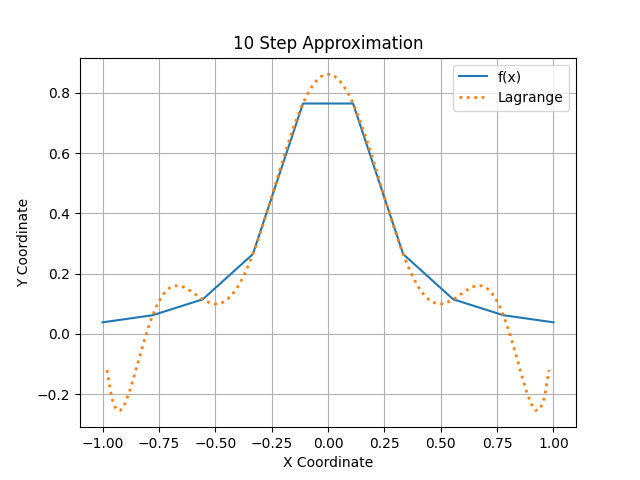

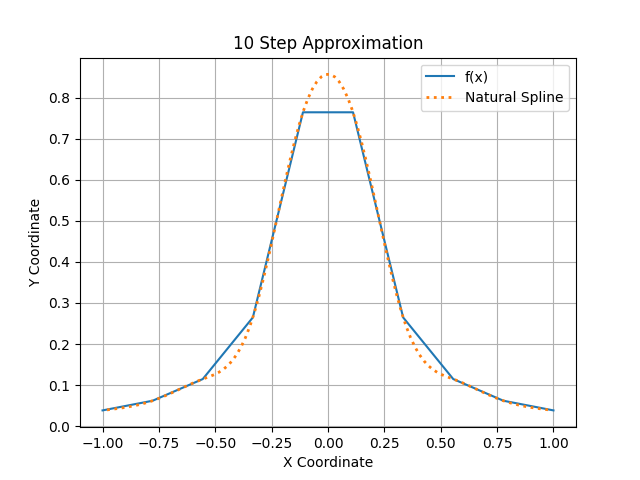

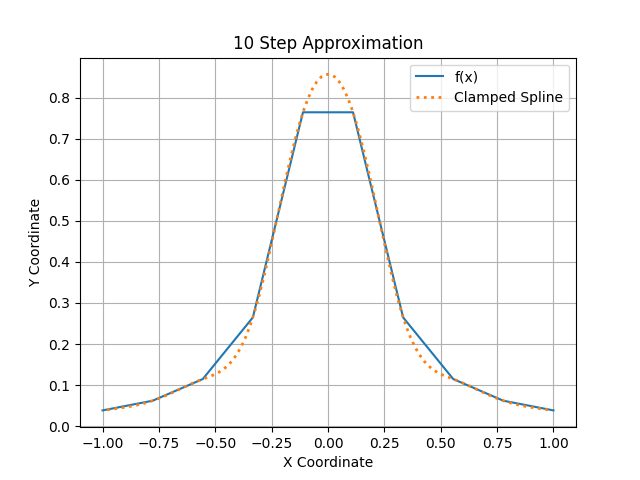

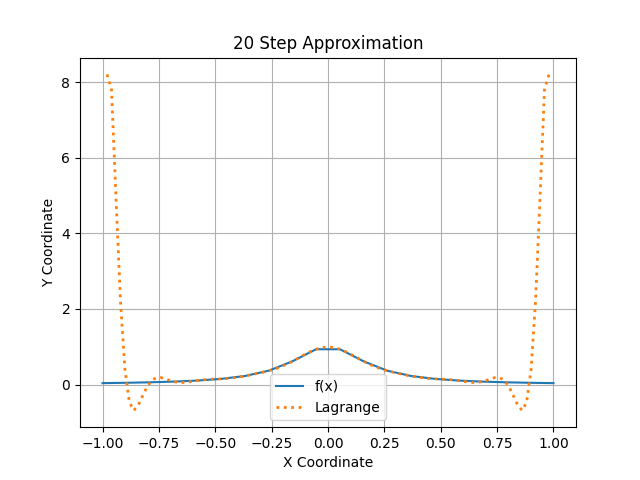

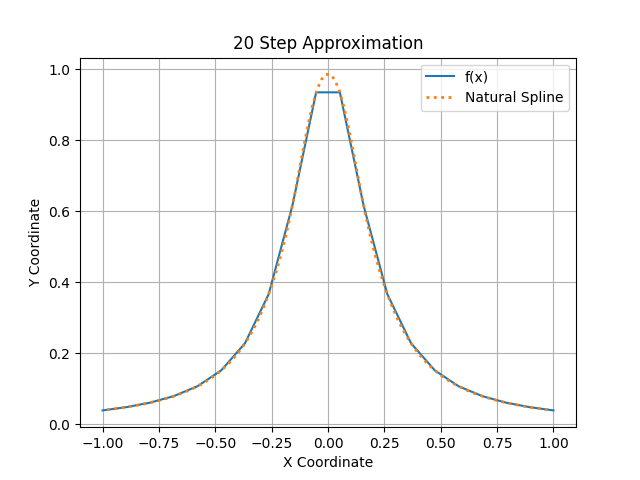

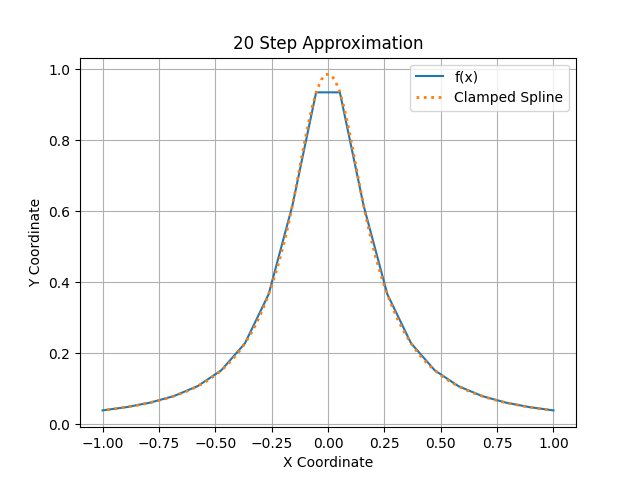

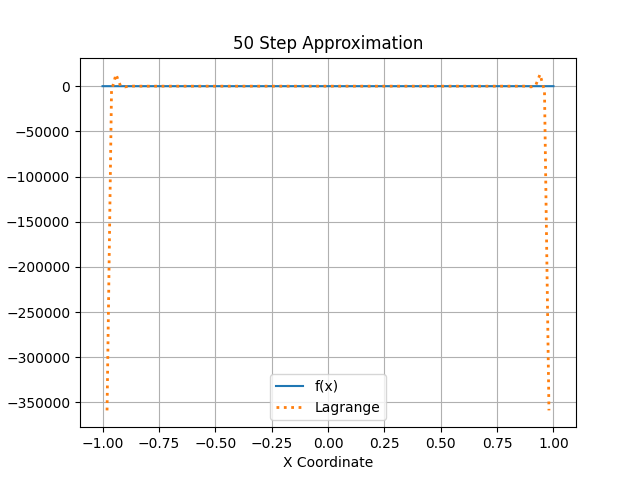

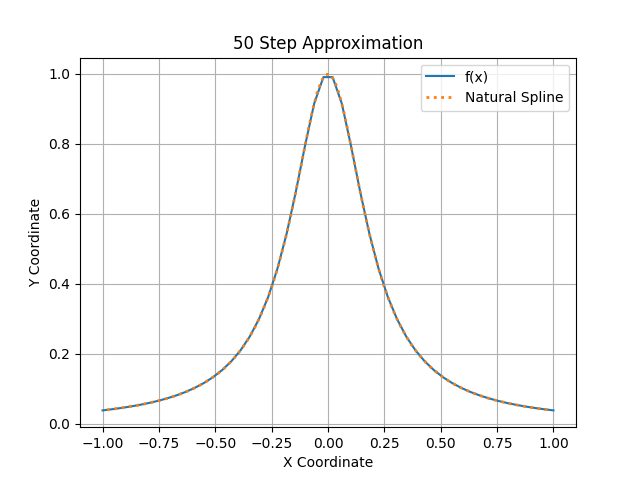

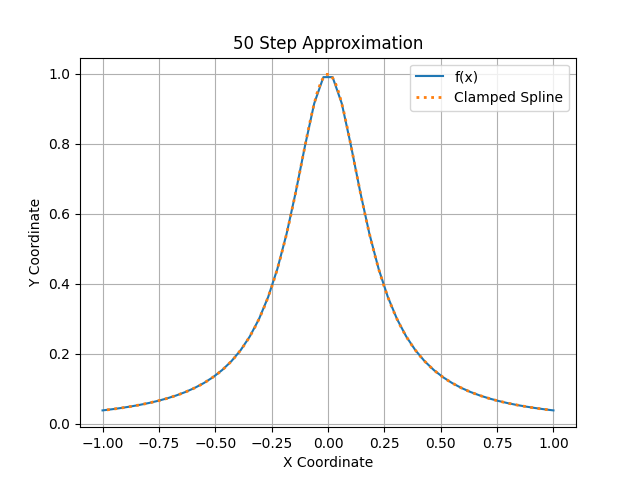

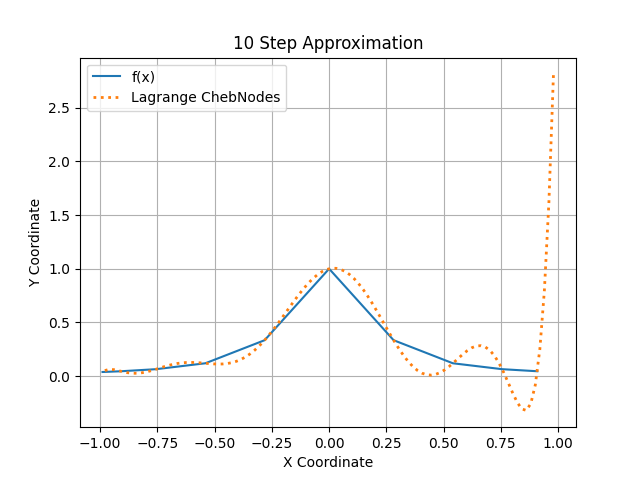

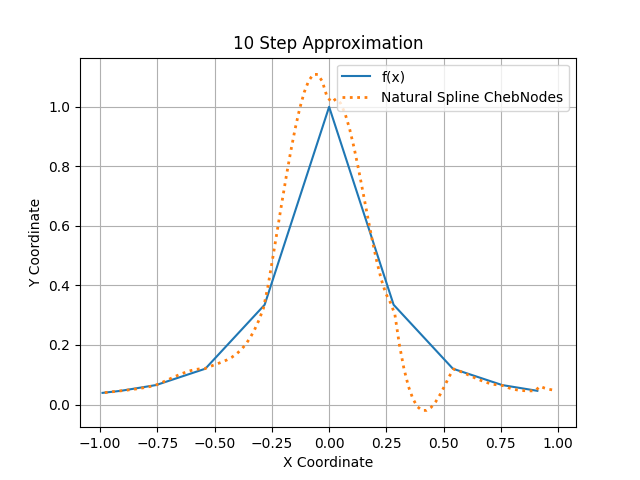

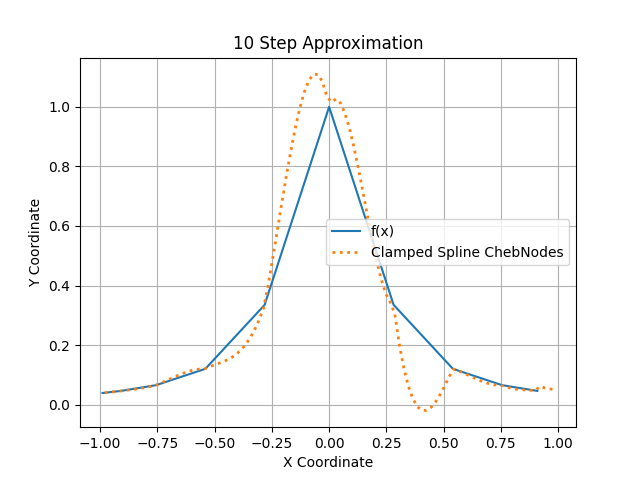

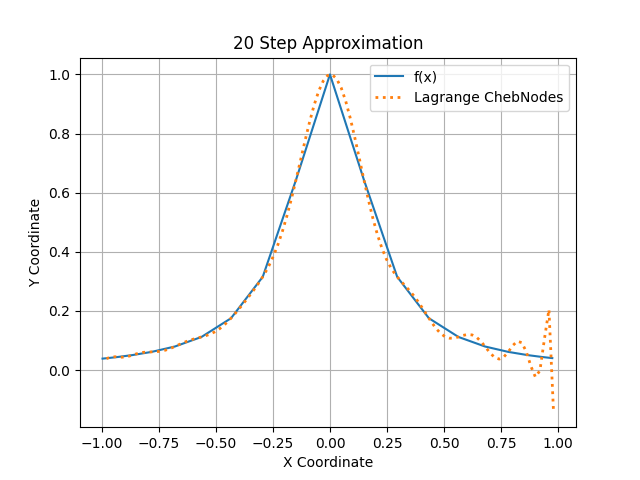

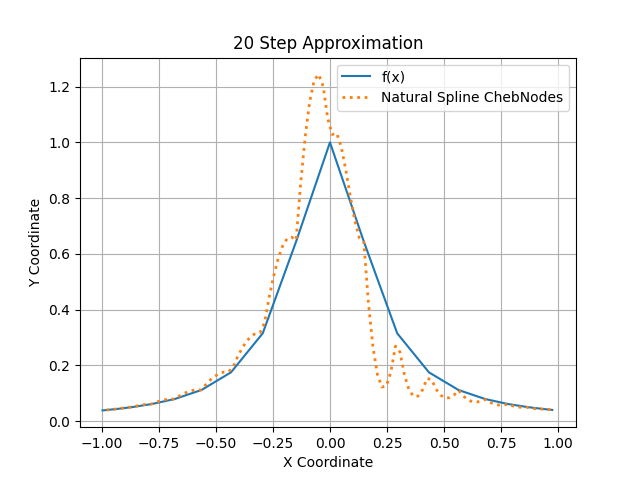

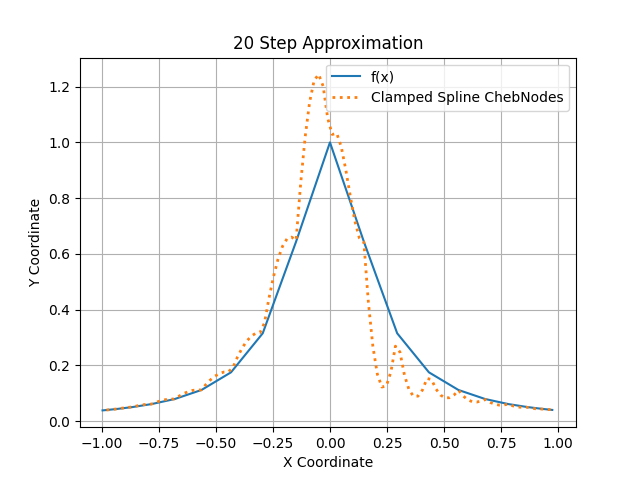

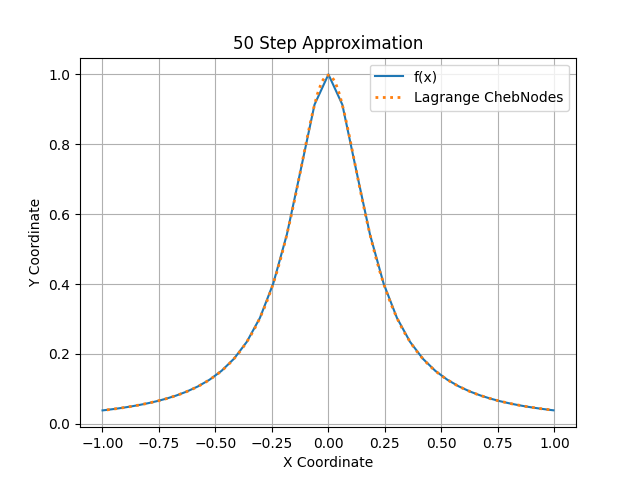

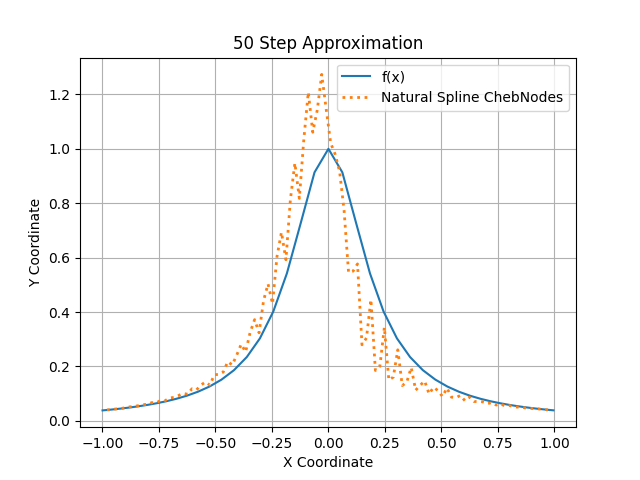

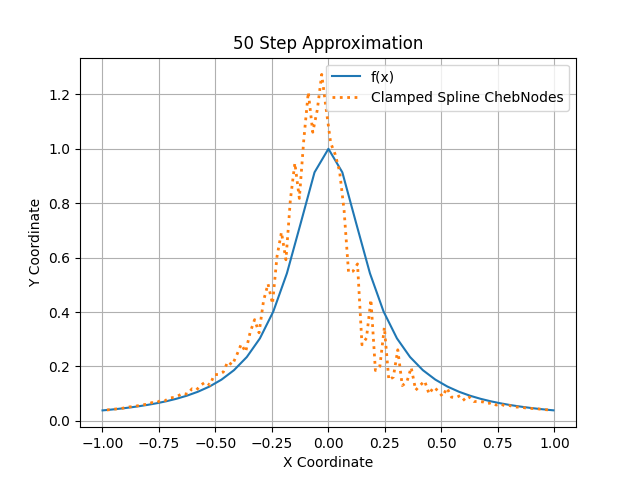

In [51]:
#call the functions to figures to approximate f!!
main(part_a = True) # all the f approximations


/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/915910882.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  st[i] = S[j, 0] + S[j, 1]*temp + S[j, 2]*(temp)**(2)+S[j, 3]*(temp)**(3)


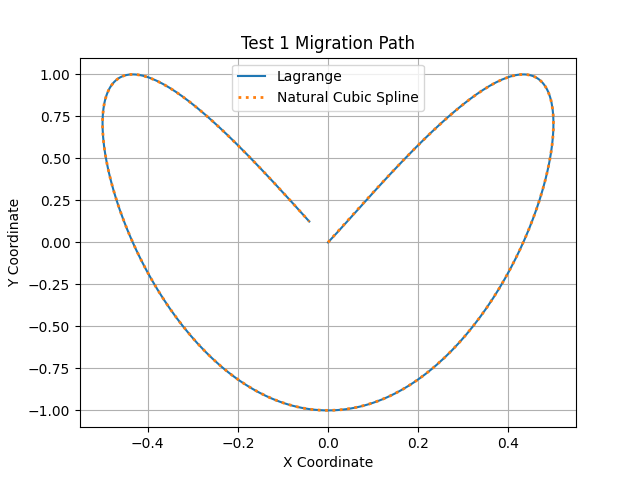

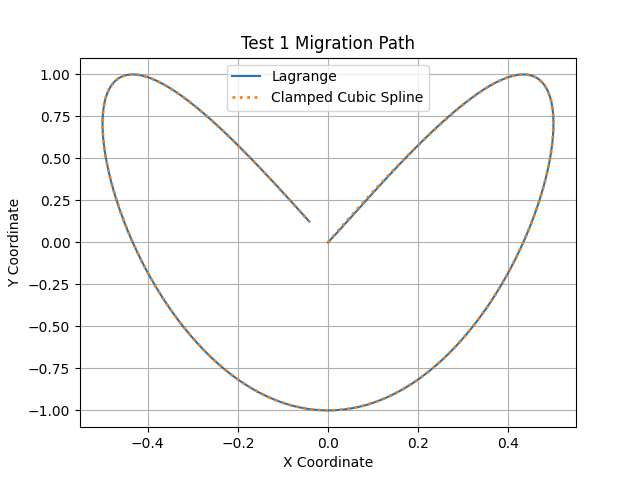

/var/folders/gm/9y57_3fs709d6dzmdn5zj_s00000gn/T/ipykernel_10642/1364683214.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plot = plt.figure(figName)


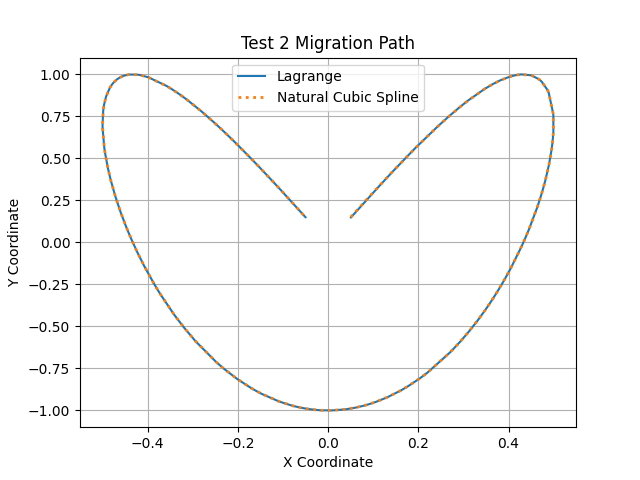

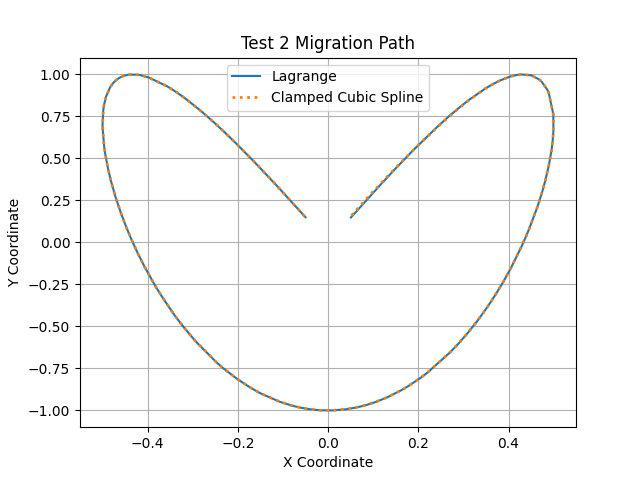

In [52]:
#Run the spline test!!
main(part_a = False, part_b = True, test1 = True, test2 = False) #equidistant nodes
main(part_a = False, part_b = True, test1 = False, test2 = True) #uniformly dist nodes
